# EARIN Lab 4
### Michał Szopiński 300182, Tomasz Juraniec 293109

## Introduction

The goal of this laboratory was to write a program to distinguish between legitimate and anomalous network traffic for the purpose of DDoS attack protection. Two sepearate models were to be used and compared: logistic regression and random forest.

The SKlearn package was used to handle the machine learning. Seaborn and Matplotlib were used to plot the data. Numpy and Pandas were used for bulk data processing.

In [44]:
from scipy.io import arff
import pandas
import numpy

import matplotlib.pyplot
import seaborn

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score


## Importing the data

Data was imported from two ARFF files, one containing the training data set and one containing the testing data set.

In [45]:
train_input = arff.loadarff("KDDTrain+.arff")
test_input = arff.loadarff("KDDTest+.arff")

train_df = pandas.DataFrame(train_input[0])
test_df = pandas.DataFrame(test_input[0])

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'ftp_data',b'SF',491.0,0.0,b'0',0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,b'normal'
1,0.0,b'udp',b'other',b'SF',146.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,b'normal'
2,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,b'anomaly'
3,0.0,b'tcp',b'http',b'SF',232.0,8153.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,b'normal'
4,0.0,b'tcp',b'http',b'SF',199.0,420.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,b'normal'


## Analyzing the data

The imported data set consisted of many features characterizing network traffic. Among them was the `class` feature, which classifies the traffic into legitimate and anomalous. This class enables us to train the model and to test it. There were no missing values in the data set.

In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  float64
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  float64
 5   dst_bytes                    125973 non-null  float64
 6   land                         125973 non-null  object 
 7   wrong_fragment               125973 non-null  float64
 8   urgent                       125973 non-null  float64
 9   hot                          125973 non-null  float64
 10  num_failed_logins            125973 non-null  float64
 11  logged_in                    125973 non-null  object 
 12  num_compromised              125973 non-null  float64
 13 

In [47]:
train_df.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.022687,0.000111,0.204409,0.001222,0.279250,0.001342,0.001103,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.253530,0.014366,2.149968,0.045239,23.942042,0.036603,0.045154,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,3.000000,3.000000,77.000000,5.000000,7479.000000,1.000000,2.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Preprocessing

The next step is to prepare the data for the analysis. This step consists of checking categorical variables, transforming them to numerical format, checking which information is not obligatory and preparing data to be used within the specific models.

### Encoding categorical features

Before the data is fed into ML algorithms, it must be preprocessed. This involves encoding categorical values into numerical ones. The `service` feature, due to a large number of values, was ecoded using ordinal encoding. 

In [6]:
print("Training set:")
for col in train_df.columns:
    if train_df[col].dtypes == "object":
        unique_categories = len(train_df[col].unique())
        print("Category count for '{}': {}".format(col, unique_categories))

print("Occurrence of service categories:")
print(train_df["service"].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'land' has 2 categories
Feature 'logged_in' has 2 categories
Feature 'is_host_login' has 2 categories
Feature 'is_guest_login' has 2 categories
Feature 'class' has 2 categories

Distribution of categories in service:
b'http'        40338
b'private'     21853
b'domain_u'     9043
b'smtp'         7313
b'ftp_data'     6860
Name: service, dtype: int64


In [7]:
print("Test set:")
for col in train_df.columns:
    if train_df[col].dtypes == "object":
        unique_categories = len(train_df[col].unique())
        print("Category count for '{}': {}".format(col, unique_categories))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'land' has 2 categories
Feature 'logged_in' has 2 categories
Feature 'is_host_login' has 2 categories
Feature 'is_guest_login' has 2 categories
Feature 'class' has 2 categories


In [10]:

train_df['service'] = train_df['service'].astype('category')
cat_columns = train_df.select_dtypes(['category']).columns
train_df[cat_columns] = train_df[cat_columns].apply(lambda x: x.cat.codes)

train_df[['class']] = OrdinalEncoder().fit_transform(train_df[['class']])

train_df_encoded = pandas.get_dummies(data=train_df, columns=list(train_df.select_dtypes(['object']).columns))

In [11]:
test_df['service'] = test_df['service'].astype('category')
cat_columns = test_df.select_dtypes(['category']).columns
test_df[cat_columns] = test_df[cat_columns].apply(lambda x: x.cat.codes)

test_df[['class']] = OrdinalEncoder().fit_transform(test_df[['class']])

test_df_encoded = pandas.get_dummies(data=test_df, columns=list(test_df.select_dtypes(['object']).columns))

## Correlation matrix

To analyze how each feature impacts other features, a correlation matrix is plotted. It is a heat map where correlation patterns may be easily noticed by a human.

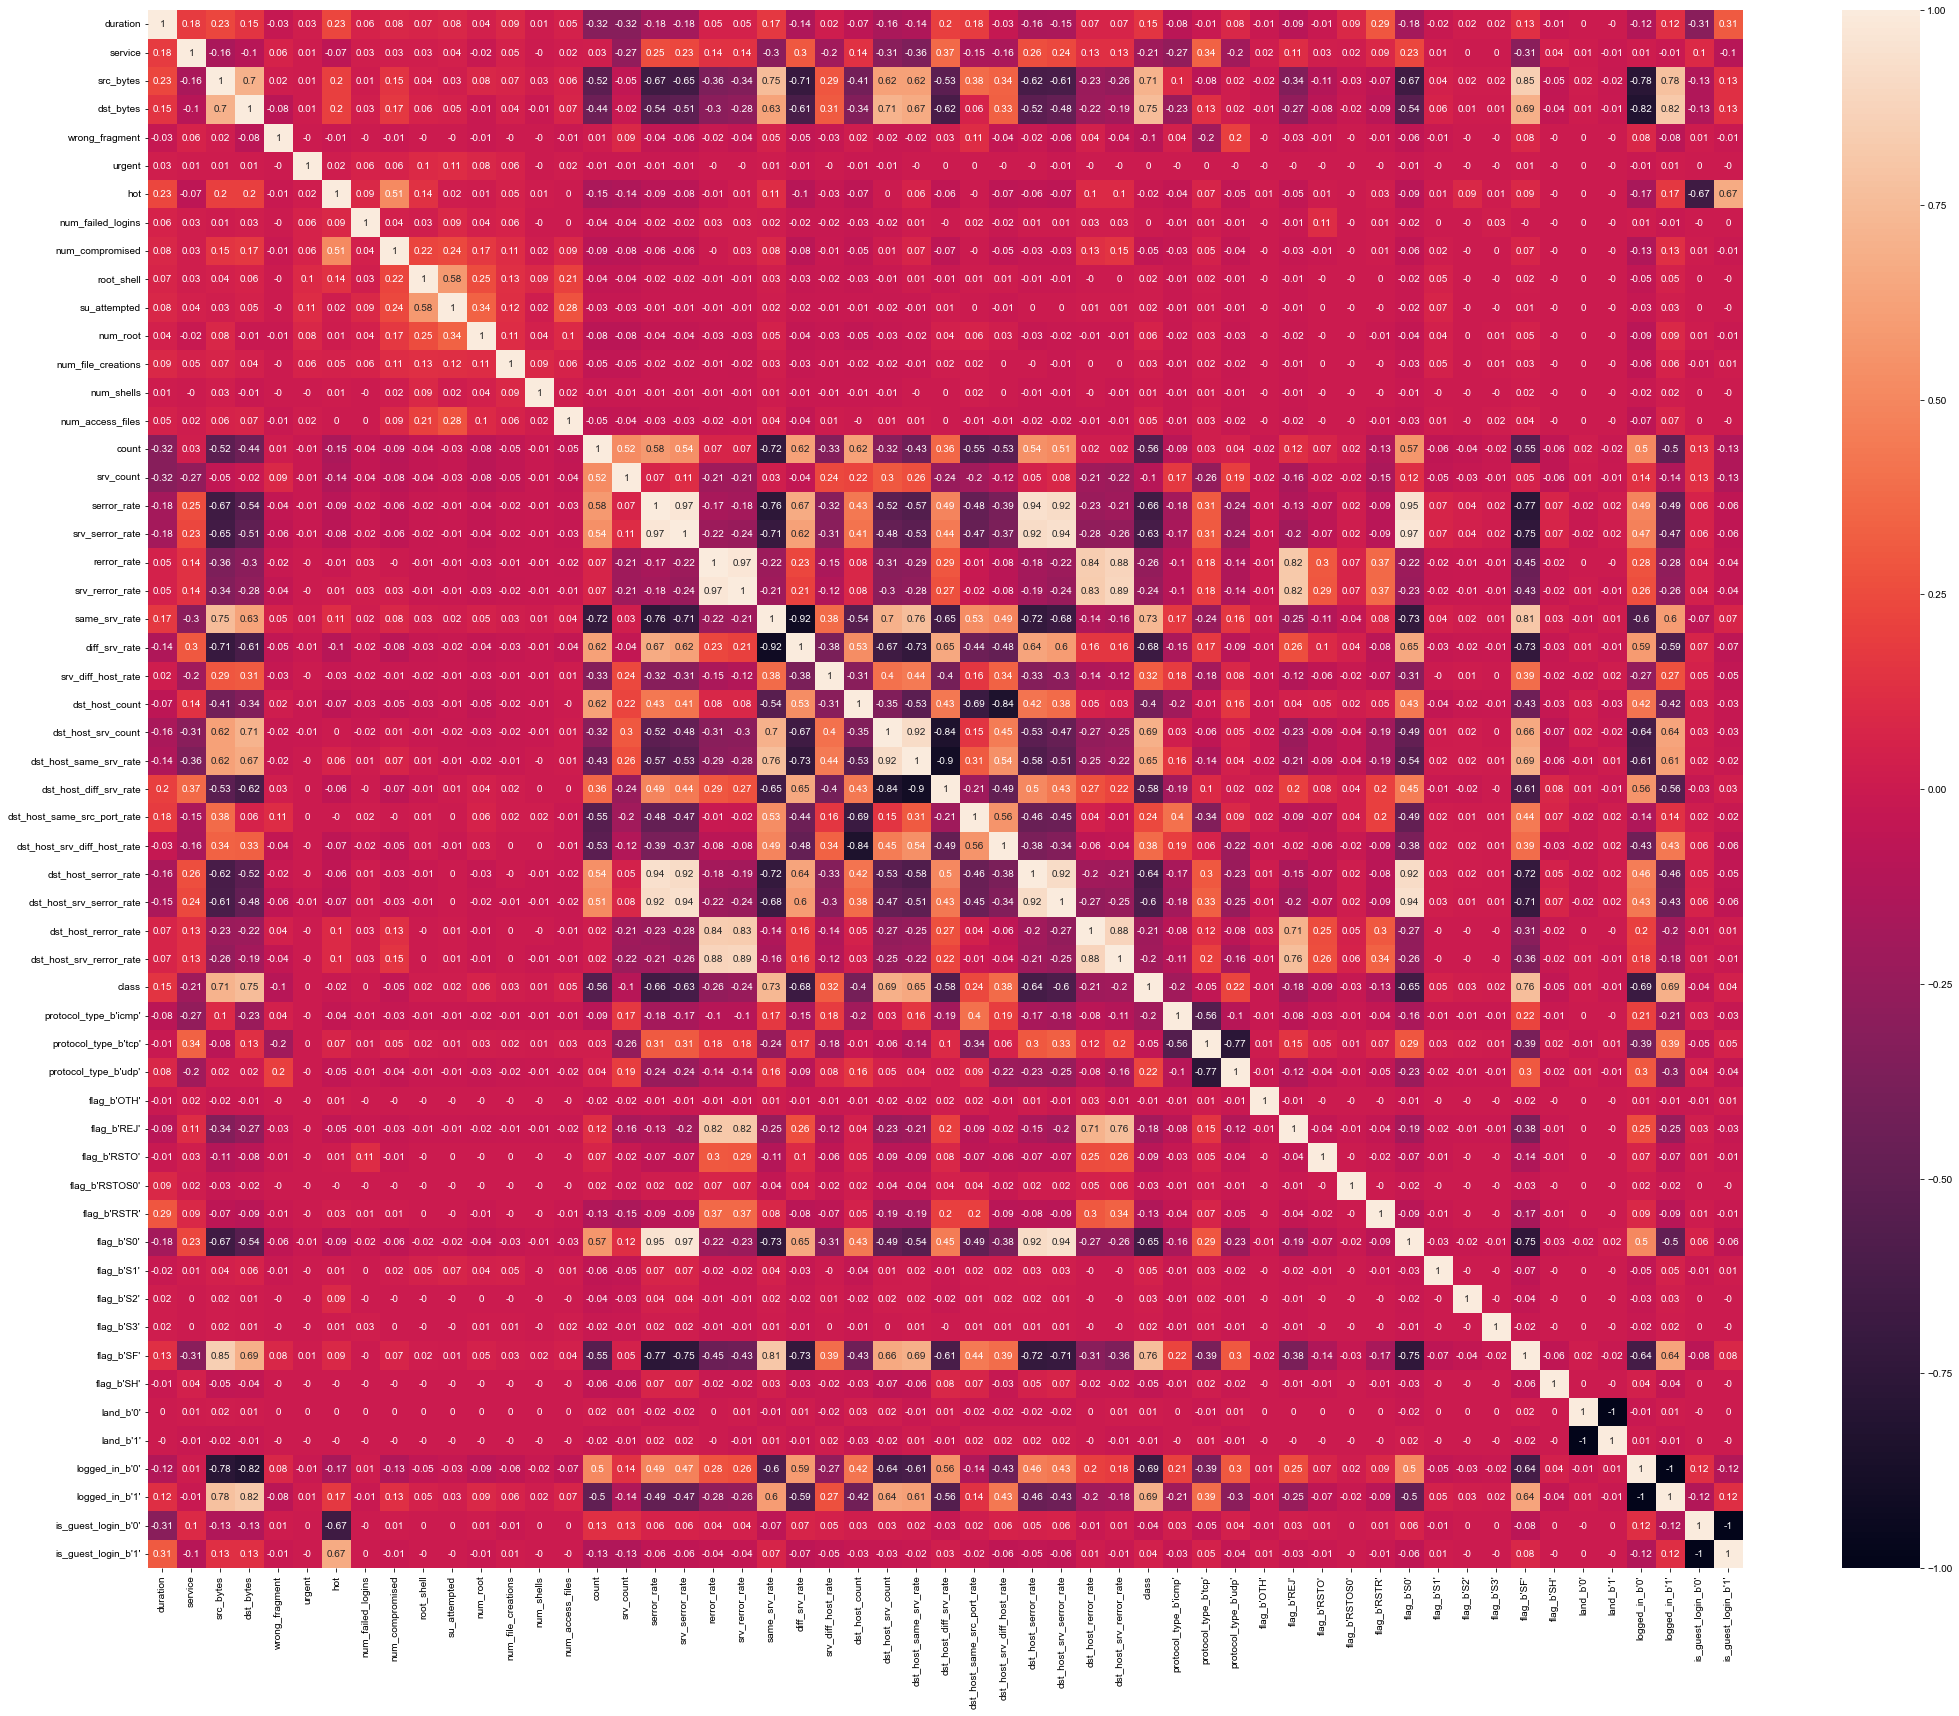

In [12]:
matplotlib.pyplot.figure(figsize=(30, 24))

seaborn.heatmap(train_df_encoded.corr(method="spearman").round(2), annot=True)
seaborn.set(rc={
    "figure.figsize": (120, 80)
})

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## Feature selection

Features were manually selected based on their correlation to the `class` feature. Significant colinearity may be observed between each of the selected features.

In [35]:
features = [
    "src_bytes",
    "dst_bytes",
    "serror_rate",
    "srv_serror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "dst_host_srv_count",
    "flag_b'SF'",
    "logged_in_b'0'"
]

x_train = train_df_encoded[features]
y_train = train_df_encoded["class"]

x_test = test_df_encoded[features]
y_test = test_df_encoded["class"]

## Hyperparameter optimization

To ensure best possible results for the random forest model, the hyperparameters were optimized using randomized search. The logistic regression model does not take any hyperparameters, and as such doesn't require any preliminary optimization.

In [43]:
hyper_params = {
    'n_estimators': [int(x) for x in numpy.linspace(start = 10, stop = 100, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in numpy.linspace(10, 110, num = 10)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

randomized_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=hyper_params, n_iter=100, random_state=2137, cv=3, n_jobs=-1, verbose=3)
randomized_search.fit(x_train, y_train)

print("Best hyperparameter optimization parameters:")
print(randomized_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameter optimization parameters:
{'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 32, 'bootstrap': False}


## Training

Models were trained using the training set and their predictions were tested against bot the train set and the test set. Testing against the training set is a useful method to detect overfitting.

The standard scaler was used to improve the results.

### Logistic regression

In [36]:
standard_scaler = StandardScaler()
standard_scaler = standard_scaler.fit(x_train)

x_train_scaled = standard_scaler.transform(x_train)
x_test_scaled = standard_scaler.transform(x_test)

logistic_regression = LogisticRegression(max_iter=400)
logistic_regression.fit(x_train_scaled, y_train)

y_train_pred = logistic_regression.predict(x_train_scaled)
y_test_pred = logistic_regression.predict(x_test_scaled)

In [38]:
print("Accuracy, logistic regression, train data: " + str(accuracy_score(y_train.values, y_train_pred)))
print("Precision, logistic regression, train data: " + str(precision_score(y_train.values, y_train_pred)))
print("Accuracy, logistic regression, test data: " + str(accuracy_score(y_test.values, y_test_pred)))
print("Precision, logistic regression, test data: " + str(precision_score(y_test.values, y_test_pred)))

Accuracy train set prediction: 0.8864359823136704
Precision score train set prediction: 0.8849453468623437
Accuracy test set prediction: 0.7534155429382541
Precision score test set prediction: 0.6482010279840091


### Random forest classifier

In [40]:
random_forest_classifier = RandomForestClassifier(**randomized_search.best_params_)
random_forest_classifier.fit(x_train, y_train)

y_train_pred = random_forest_classifier.predict(x_train)
y_test_pred = random_forest_classifier.predict(x_test)

In [42]:
print("Accuracy, random forest, train data: " + str(accuracy_score(y_train.values, y_train_pred)))
print("Precision, random forest, train data: " + str(precision_score(y_train.values, y_train_pred)))
print("Accuracy, random forest, test data: " + str(accuracy_score(y_test.values, y_test_pred)))
print("Precision, random forest, test data: " + str(precision_score(y_test.values, y_test_pred)))

Accuracy train set prediction: 0.9987537011899376
Precision score train set prediction: 0.9992865848220921
Accuracy test set prediction: 0.7708037615330021
Precision score test set prediction: 0.6597524961327521


## Conclusions

Using both models, we were able to attain an accurracy nearing 77% and a precision of 65%. In the case of the random forest, overfitting is visible, with the accuracy nearly equal to 100%.